# Curve Fitting Uncertainties with PSL Uncertainty Calculator

This notebook demonstrates curve fitting, both linear and non-linear, using the curvefit module of the PSL uncertainty calculator. The model parameters (e.g. slope and intercept in the linear case) are fit using a least-squares regression. Uncertainties in the parameters are computed using four different methods for comparison. For a description of each method, see the `Curvefit Methods` notebook.

The `CurveFit` class takes `func` as an argument. This can be a callable Python function, a sympifyable string expression, or one of the predefined function names as follows:

- `line` - (default): $y = a + bx$
- `exp` - Exponential: $y = a exp{(x/b)} + c$
- `decay` - Exponential decay, no offset: $y = a \exp{(-x/b)}$
- `log` - Natural Log function: $y = a + b \log{(x-c)}$
- `logistic` - Logistic growth: $y = a / (1 + \exp{((x-c)/b)}) + d$
- `quad` - Quadratic Polynomial: $y = a + bx + cx^2$
- `cubic` - Cubic Polynomial: $y = a + bx + cx^2 + dx^3$
- `poly` - General Polynomial. Provide `polyorder` parameter: $y = a + bx + cx^2 ... kx^n$

Once the pamrater values and uncertainties are computed, functions for finding confidence band of the fit line and a prediction band for new measurements are also generated and plotted.

The fit values and uncertainties are found using the four methods described below for comparison.

#### Definitions:
Confidence band: Uncertainty that the fit line passes through the true mean value of the line

Prediction band: Uncertainty in taking a new measurement at a given X value.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.special import wofz  # For the Voigt function example

import suncal
from suncal import curvefit

In [2]:
def plotit(f):
    ''' Calculate and plot comparison of fits '''
    mcmc = hasattr(f, 'mcmc')
    cols = 4 if mcmc else 3
    fig, ax = plt.subplots(ncols=cols, figsize=(14,4))
    f.gum.plot_summary(ax=ax[0])
    f.lsq.plot_summary(ax=ax[1])
    f.mc.plot_summary(ax=ax[2])
    if mcmc:
        f.mcmc.plot_summary(ax=ax[3])
        ax[3].set_title('Markov Chain MC')
    ax[0].set_title('GUM')
    ax[1].set_title('Least-Squares')
    ax[2].set_title('Monte Carlo')
    fig.tight_layout()

## Linear Fit

For a straight line, use the simplified ArrayLineFit class (a special case of the more generic ArrayCurveFit class).




Method                   |b     |u(b)  |a    |u(a) 
-------------------------|------|------|-----|-----
Least Squares            |0.353 |0.059 |-1.7 |1.8  
GUM Approximation        |0.353 |0.059 |-1.7 |1.8  
Monte Carlo              |0.354 |0.059 |-1.8 |1.8  
Markov-Chain Monte Carlo |0.347 |0.061 |-1.5 |1.8  



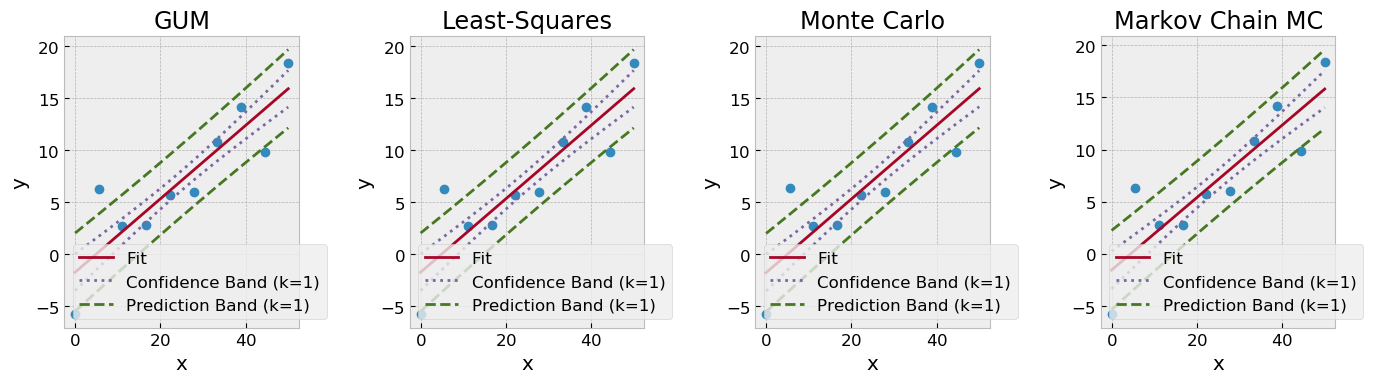

In [3]:
# Generate some data
a, b = -5, .5
uy = 3
x = np.linspace(0,50,num=10)
y = a + b * x + np.random.normal(loc=0, scale=uy, size=len(x))

# Compute the fit
arr = curvefit.Array(x, y, uy=uy)
f = curvefit.CurveFit(arr)
out = f.calculate(gum=True, mc=True, lsq=True, mcmc=True)
display(out)
plotit(out)

# Non-linear fitting

Common functions for quadratic, cubic, polynomial, and exponential are predefined in the CurveFit class and can be used by passing a string argument ('quad', 'cubic', 'poly', or 'exp') to the CurveFit.




Method                   |a    |u(a) |b      |u(b)  |c     |u(c)  
-------------------------|-----|-----|-------|------|------|------
Least Squares            |2.04 |0.13 |-0.990 |0.099 |0.253 |0.025 
GUM Approximation        |2.04 |0.13 |-0.990 |0.099 |0.253 |0.025 
Monte Carlo              |2.04 |0.13 |-0.987 |0.099 |0.252 |0.025 
Markov-Chain Monte Carlo |2.03 |0.13 |-0.99  |0.10  |0.253 |0.025 



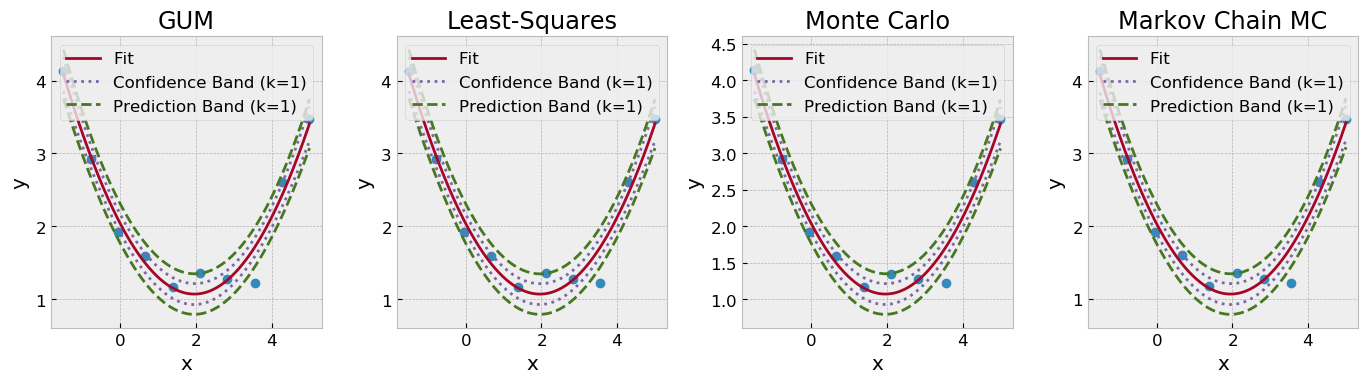

In [4]:
# Generate some quadratic data with noise
a, b, c = 2, -1, 0.25
uy = .3
x = np.linspace(-1.5, 5, num=10)
y = a + b*x + c*x*x + np.random.normal(loc=0, scale=uy, size=len(x))

# Calculate fit and uncertainty
arr = curvefit.Array(x, y, uy=uy)
f = curvefit.CurveFit(func='quad', arr=arr)
out = f.calculate(gum=True, mc=True, lsq=True, mcmc=True)
display(out)
plotit(out)




Method                   |a    |u(a) |b     |u(b) |c     |u(c) |d    |u(d) |e     |u(e) 
-------------------------|-----|-----|------|-----|------|-----|-----|-----|------|-----
Least Squares            |1.04 |0.27 |-0.49 |0.57 |-1.65 |0.39 |0.77 |0.52 |-0.19 |0.22 
GUM Approximation        |1.04 |0.27 |-0.49 |0.56 |-1.65 |0.39 |0.77 |0.53 |-0.19 |0.21 
Monte Carlo              |1.04 |0.27 |-0.47 |0.58 |-1.65 |0.40 |0.76 |0.52 |-0.19 |0.22 
Markov-Chain Monte Carlo |0.96 |0.21 |-0.33 |0.45 |-1.57 |0.37 |0.63 |0.41 |-0.21 |0.21 



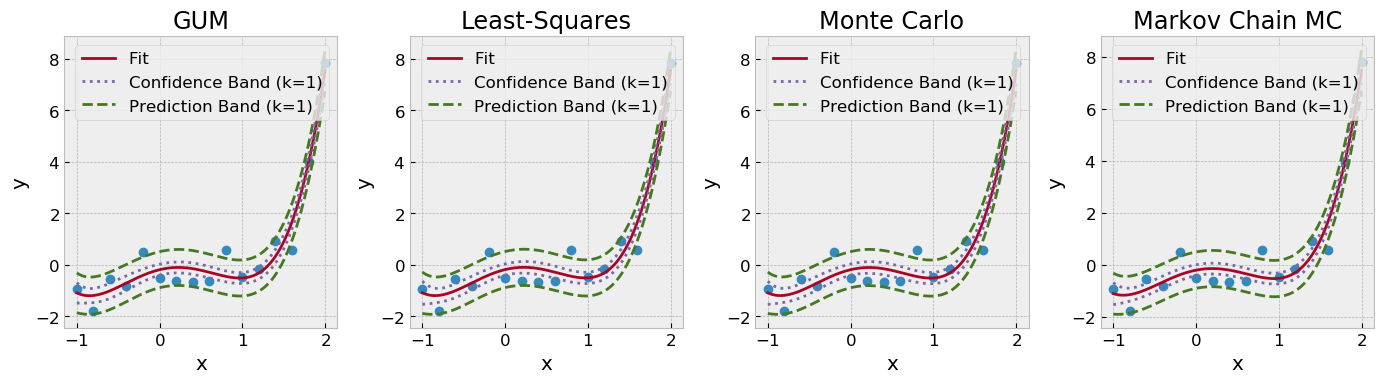

In [5]:
# Polynomial - must also specify the polyorder parameter.
uy = .5
x = np.linspace(-1, 2, num=16)
y = x**4 - 2*x**2 + np.random.normal(loc=0, scale=uy, size=len(x))

arr = curvefit.Array(x, y, uy=uy)
f = curvefit.CurveFit(arr, func='poly', polyorder=4)
out = f.calculate(gum=True, mc=True, lsq=True, mcmc=True)
display(out)
plotit(out)




Method                   |a     |u(a)  |b     |u(b) |c     |u(c)  
-------------------------|------|------|------|-----|------|------
Least Squares            |0.994 |0.072 |-1.97 |0.33 |5.013 |0.037 
GUM Approximation        |0.994 |0.078 |-1.97 |0.42 |5.013 |0.041 
Monte Carlo              |1.001 |0.071 |-2.00 |0.31 |5.009 |0.036 
Markov-Chain Monte Carlo |0.993 |0.075 |-2.07 |0.36 |5.004 |0.041 



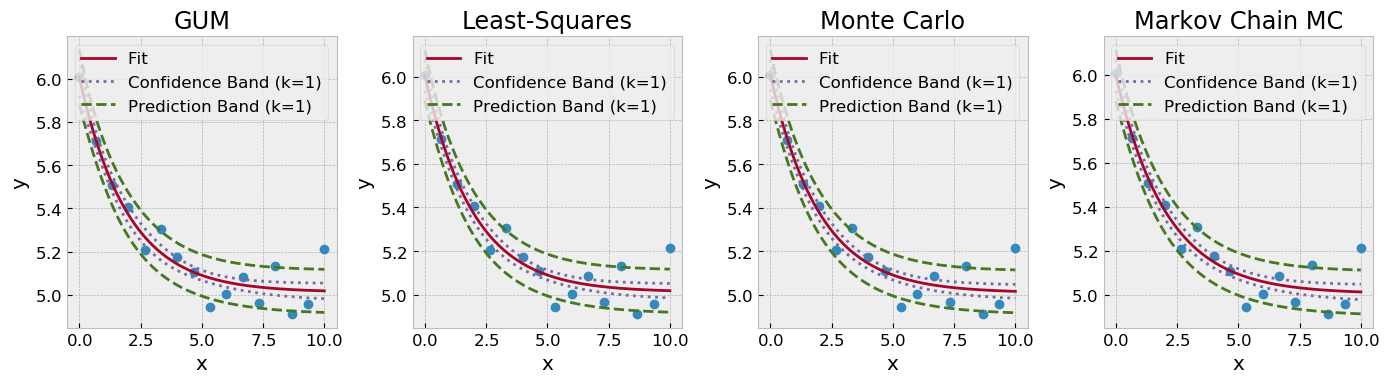

In [6]:
# Exponential
a, b = 2, 5
uy = .08
x = np.linspace(0, 10, num=16)
y = np.exp(-x/a) + b + np.random.normal(loc=0, scale=uy, size=len(x))

arr = curvefit.Array(x, y, uy=uy)
f = curvefit.CurveFit(func='exp', arr=arr, p0=(1, -2, 5))
out = f.calculate(gum=True, mc=True, lsq=True, mcmc=True)
display(out)
plotit(out)




Method                   |b    |u(b) 
-------------------------|-----|-----
Least Squares            |2.00 |0.14 
GUM Approximation        |2.00 |0.14 
Monte Carlo              |2.00 |0.14 
Markov-Chain Monte Carlo |1.99 |0.15 



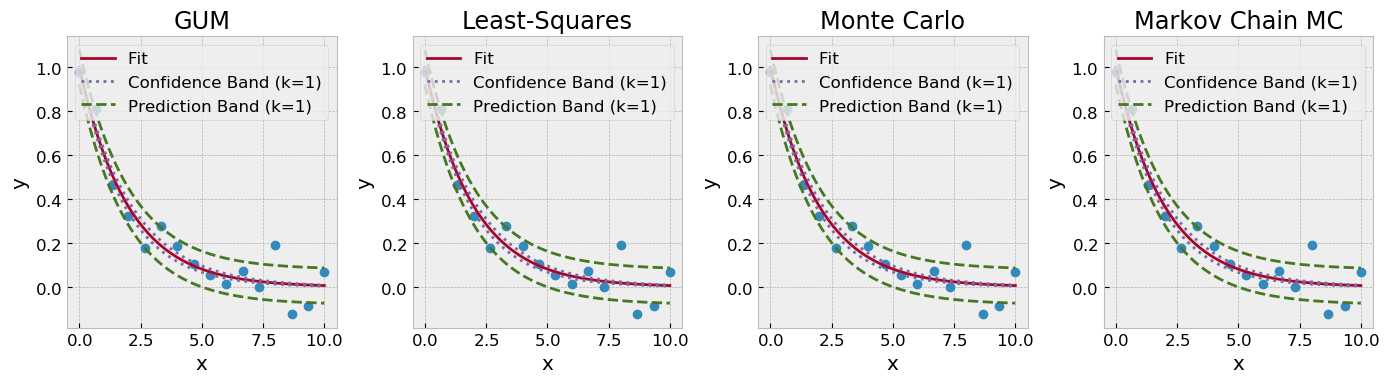

In [7]:
# Exponential, custom-defined as string expression with only one parameter
b = 2
uy = .06
x = np.linspace(0, 10, num=16)
y = np.exp(-x/b) + np.random.normal(loc=0, scale=uy, size=len(x))

arr = curvefit.Array(x, y, uy=uy)
f = curvefit.CurveFit(func='exp(-x/b)', arr=arr)
out = f.calculate(gum=True, mc=True, lsq=True, mcmc=True)
display(out)
plotit(out)




Method                   |a      |u(a) |b     |u(b) 
-------------------------|-------|-----|------|-----
Least Squares            |145.28 |0.34 |19.90 |0.28 
GUM Approximation        |145.28 |0.34 |19.90 |0.28 
Monte Carlo              |145.27 |0.34 |19.90 |0.28 
Markov-Chain Monte Carlo |145.28 |0.35 |19.91 |0.27 



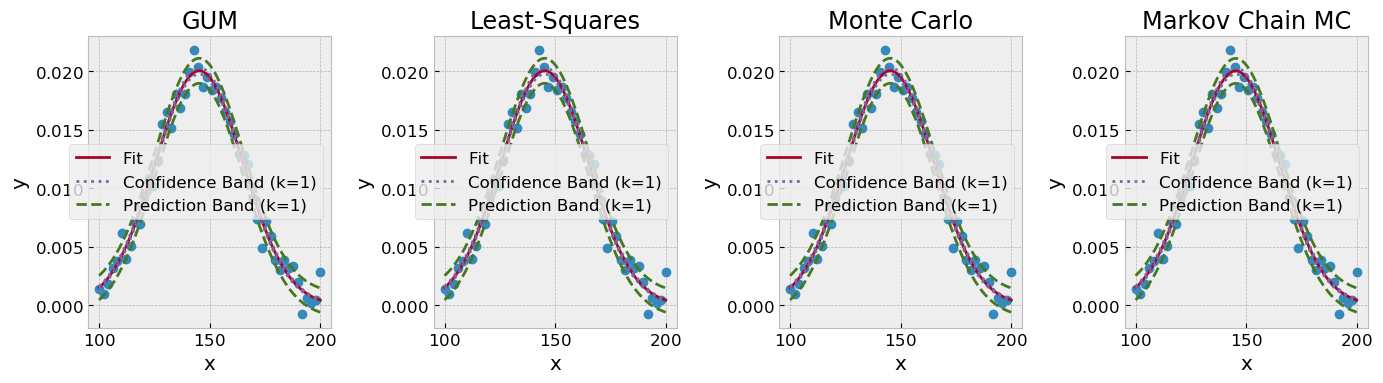

In [8]:
# Normal function - This one needs an initial guess to converge
def func(x, a, b):
    return stats.norm.pdf(x, loc=a, scale=b)

a, b = 145, 20
uy = .001
x = np.linspace(100, 200, 50)
y = func(x, a, b) + np.random.normal(loc=0, scale=uy, size=len(x))

arr = curvefit.Array(x, y, uy=uy)
f = curvefit.CurveFit(func=func, arr=arr, p0=(a, b))
out = f.calculate(gum=True, mc=True, lsq=True, mcmc=True)
display(out)
plotit(out)




Method                   |a     |u(a)  |p      |u(p)   |z     |u(z)  
-------------------------|------|------|-------|-------|------|------
Least Squares            |3.049 |0.099 |0.3935 |0.0029 |1.019 |0.071 
GUM Approximation        |3.049 |0.099 |0.3935 |0.0029 |1.019 |0.070 
Monte Carlo              |3.054 |0.098 |0.3934 |0.0029 |1.018 |0.070 
Markov-Chain Monte Carlo |3.05  |0.10  |0.3937 |0.0029 |1.023 |0.072 



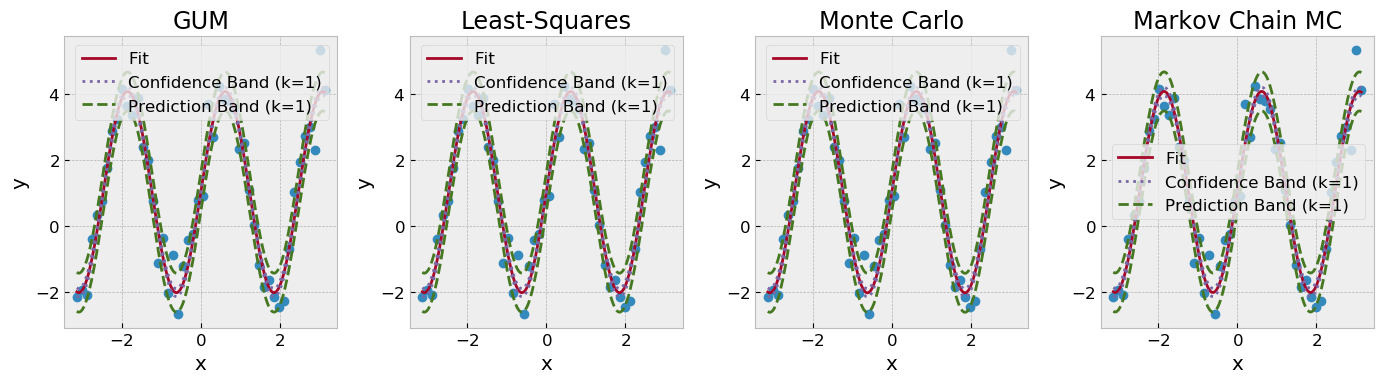

In [9]:
# sine function - Interestingly, MC needs an initial guess, but the others converge without.
def func(x, a, p, z):
    return a * np.sin(x/p) + z

a, p, z = 3, np.pi/8, 1
x = np.linspace(-np.pi, np.pi, 50)
uy = .5
y = func(x, a, p, z) + np.random.normal(loc=0, scale=uy, size=len(x))

arr = curvefit.Array(x, y, uy=uy)
f = curvefit.CurveFit(func=func, arr=arr, p0=(a, p, z))
out = f.calculate(gum=True, mc=True, lsq=True, mcmc=True)
display(out)
plotit(out)

/Users/cjdelke/miniconda3/envs/uncertosx/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in true_divide
  
/Users/cjdelke/Code/PSLUncertaintyCalc/suncal/curvefit.py:473: RuntimeWarning: overflow encountered in square
  problognew = -1/(2*sig2) * sum((self.arr.y - Ynew)**2)





Method                   |gammaG |u(gammaG) |gammaL |u(gammaL) |center |u(center) |base    |u(base) |area  |u(area) 
-------------------------|-------|----------|-------|----------|-------|----------|--------|--------|------|--------
Least Squares            |2.36   |0.58      |1.46   |0.71      |520.22 |0.11      |-0.0026 |0.0018  |1.102 |0.098   
GUM Approximation        |2.4    |2.6       |1.5    |3.3       |520.22 |0.15      |-0.0026 |0.0055  |1.10  |0.36    
Monte Carlo              |2.28   |0.63      |1.30   |0.90      |520.23 |0.11      |-0.0024 |0.0018  |1.10  |0.100   
Markov-Chain Monte Carlo |2.26   |0.56      |1.47   |0.69      |520.23 |0.12      |-0.0023 |0.0017  |1.089 |0.089   



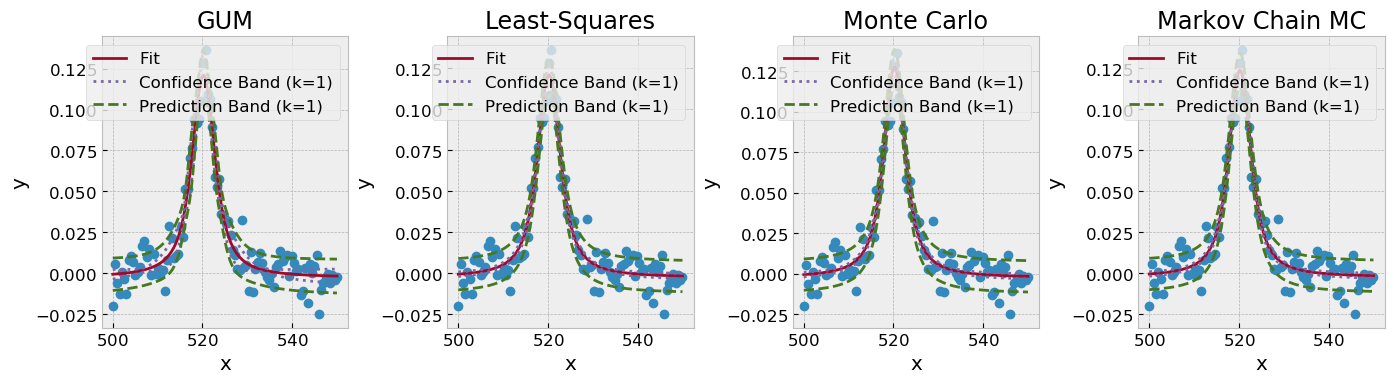

In [10]:
# Voigt function (used in Raman spectroscopy) 
# This is a case where GUM uncertainties don't match other methods.
def func(x, gammaG, gammaL, center, base, area):
    ''' Voigt function, shifted/scaled. '''
    sigma = gammaL / np.sqrt(2 * np.log(2))
    vv = np.real(wofz((x-center + 1j*gammaG)/sigma/np.sqrt(2))) / sigma / np.sqrt(2*np.pi)
    vv = area*vv
    vv += base
    return vv

args = [2, 1.8, 520, 0, 1]
x = np.linspace(500, 550, 100)
uy = .01
y = func(x, *args) + np.random.normal(loc=0, scale=uy, size=len(x))

arr = curvefit.Array(x, y, uy=uy)
f = curvefit.CurveFit(func=func, arr=arr, p0=args)
out = f.calculate(gum=True, mc=True, lsq=True, mcmc=True)
display(out)
plotit(out)

## Uncertainty in X values

The same tests can be repated with uncertainties in the X values. In this case, the curve fit will use orthogonal distance regression, or the York method if the model is linear. Compared to the ux=0 examples above, the uncertainty should be a bit higher for each parameter.

Note the Markov-Chain Monte Carlo method does not currently incorporte uncertainty in X values. Add the `mcmc=True` parameter to the `calculate()` method to see the discrepancy in results.




Method            |b     |u(b)  |a    |u(a) 
------------------|------|------|-----|-----
Least Squares     |0.397 |0.059 |-3.6 |1.8  
GUM Approximation |0.393 |0.059 |-3.5 |1.8  
Monte Carlo       |0.391 |0.059 |-3.4 |1.8  



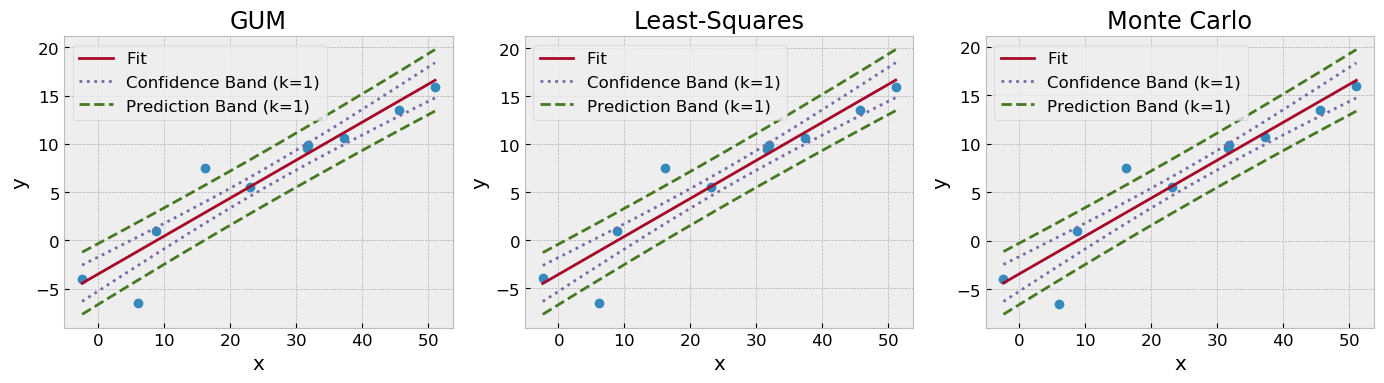

In [11]:
# Generate linear data with uncertainty in x and y
a, b = -5, .5
uy = 3
ux = 2
x = np.linspace(0,50,num=10)
y = a + b * x + np.random.normal(loc=0, scale=uy, size=len(x))
x = x + np.random.normal(loc=0, scale=ux, size=len(x))

# Compute the fit
arr = curvefit.Array(x, y, ux=ux, uy=uy)
f = curvefit.CurveFit(arr, p0=[-5, 0.5])
out = f.calculate(gum=True, mc=True, lsq=True, mcmc=False)
display(out)
plotit(out)




Method            |a    |u(a) |p      |u(p)   |z    |u(z) 
------------------|-----|-----|-------|-------|-----|-----
Least Squares     |3.51 |0.26 |0.3815 |0.0065 |0.89 |0.19 
GUM Approximation |2.77 |0.24 |0.3872 |0.0075 |0.91 |0.16 
Monte Carlo       |2.44 |0.21 |0.3928 |0.0075 |0.92 |0.14 



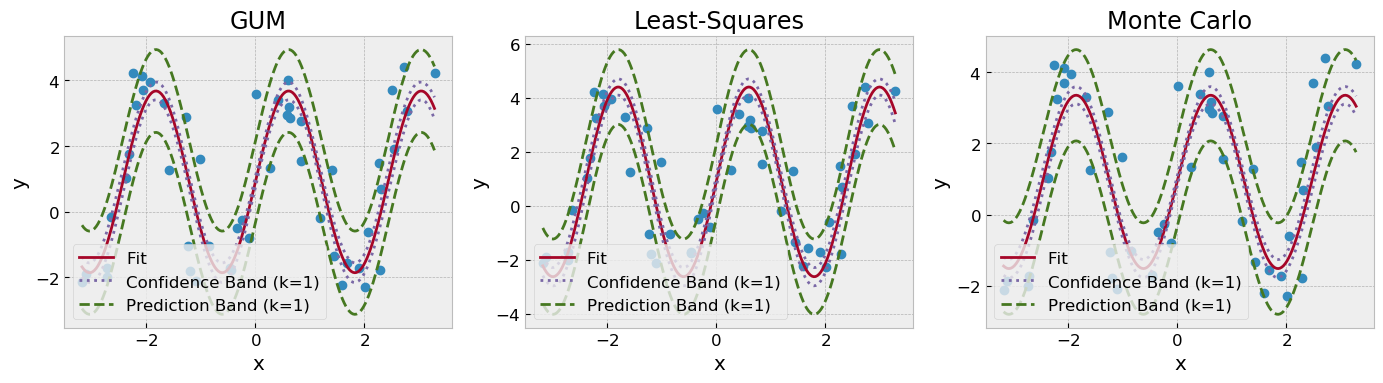

In [12]:
# sine function with uncertainty in x and y
def func(x, a, p, z):
    return a * np.sin(x/p) + z

a, p, z = 3, np.pi/8, 1
x = np.linspace(-np.pi, np.pi, 50)
uy = .5
ux = .2
y = func(x, a, p, z) + np.random.normal(loc=0, scale=uy, size=len(x))
x = x + np.random.normal(loc=0, scale=ux, size=len(x))

arr = curvefit.Array(x, y, ux=ux, uy=uy)
f = curvefit.CurveFit(func=func, arr=arr, p0=(a, p, z))
out = f.calculate(gum=True, mc=True, lsq=True, mcmc=False)
display(out)
plotit(out)